In [1]:
%matplotlib widget
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter


from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size

from sklearn.cluster import Birch                       
from sklearn.metrics import silhouette_score

In [10]:
#functions for plotting pre clustering

def make_string(vel): # turns velocity values into strings, useful for plot labels
    string= str(vel[0])+ ' - '+str(vel[1])+ ' km/s '
    return string

def vis_mom(m0,m1,m2,wcs): #plots moment 0 maps with colourbar
    fig = plt.figure()
    fig.suptitle('Moment Maps')
    
    fig.add_subplot(131,projection=wcs)
    im1=plt.imshow(m0)
    plt.title('M0')
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('K km/s')
    cbar.update_ticks()

    fig.add_subplot(132,projection=wcs)
    im2=plt.imshow(m1,vmin=100,vmax=606)
    plt.title('M1')
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('km/s')
    cbar.update_ticks()

    fig.add_subplot(133,projection=wcs)
    im3=plt.imshow(m2,vmin=0,vmax=610)
    plt.title('M2')
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('km/s')
    cbar.update_ticks()

    plt.show()

def plot_filtered(m0,m1,m2,chunk):
    fig = plt.figure()
    fig.suptitle('Masked Moment Maps')
        
    fig.add_subplot(131,projection=wcs)
    im1=plt.imshow(m0)
    plt.title('M0')
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('K km/s')
    cbar.update_ticks()

    fig.add_subplot(132,projection=wcs)
    im2=plt.imshow(m1,vmin=vels[chunk][0],vmax=vels[chunk][1])
    plt.title('M1')
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('km/s')
    cbar.update_ticks()

    fig.add_subplot(133,projection=wcs)
    im3=plt.imshow(m2,vmin=0,vmax=2000)
    plt.title('M2')
    cbar=plt.colorbar()
    cbar.formatter = ScalarFormatter(useMathText=False)
    cbar.ax.set_ylabel('km/s')
    cbar.update_ticks()
    plt.show()
    
def scatter_maps(m0,m1,m2,z=False):
    plt.figure()
    plt.scatter(m1,m0,c=m2,s=0.6)
    plt.xlabel('Vel km/s')
    plt.ylabel('Intensity K km/s')
    if z==True:   #display z axis
        plt.colorbar(label='Velocity dispersion [km/s]')
        plt.scatter(m1,m0,c=m2,s=0.6)
    else:#displays clusters on z axis
        cmap = plt.cm.jet
        norm = mpl.colors.BoundaryNorm(np.arange(np.nanmin(m2),np.nanmax(m2)+2,1),cmap.N)
        plt.scatter(m1,m0,c=m2,s=0.6,cmap=cmap,norm=norm)
        plt.colorbar(ticks=np.arange(np.nanmin(m2),np.nanmax(m2)+2,1))
    plt.show()

#Clustering Functions
def reconstruct(data, labels, reshape=True):
    """ Reconstructs the clustering labels to be of shape 75,61. If reshape=False, return a flattened array instead"""
    if (len(data.flatten())-len(labels)) != np.sum(np.isnan(data.flatten())):
        raise ValueError("Dimensions do not match")
    ret = []
    for i in data.flatten():
        if np.isnan(i):
            ret.append(np.nan)
        else:
            first, labels = labels[0], labels[1:]
            ret.append(first)
    if reshape:
        return np.array(ret).reshape(np.shape(data)[0],np.shape(data)[1])
    return ret

def SI_plot(index,score):
    plt.figure()
    plt.scatter(index,score,color='k',s=0.7)
    plt.xlabel('Number of clusters')
    plt.ylabel('Score')
    plt.title('silhouette index')
    plt.show()

def run_clustering(m0,m1,m2,clusters):
#runs clustering for optiomal number of clusters
    ClusterLabels = getCluster((m0, m1,m2), threshold=0.1, n_clusters=clusters)
    ClusterLabels_ = reconstruct(m0, ClusterLabels) 
    scatter_maps(m0,m1,ClusterLabels_)

    return ClusterLabels,ClusterLabels_

def SI_analysis(m0,m1,m2,num_range):
    scores = []
    index = []
    for i in range(num_range[0],num_range[1]):
        print(i)
        labs, Y = getCluster((m0, m1,m2), threshold=0.1, n_clusters=i, getData=True)
        scores.append(silhouette_score(Y, labs))
        index.append(i)

    SI_plot(index,scores)
    
def getCluster(datas, threshold=0.5, n_clusters=None, getData=False, branching_factor=50):
    X = []
    if isinstance(datas, tuple):#check if input data is a tuple
        for i in range(len(datas)):#flatten elements of the tuple and remove NaN values
            X.append( ((datas[i])[~np.isnan(datas[i])]).flatten() )
        Y = np.array(X)#convert to array
        Y = Y.T#transpose for clustering
        #run Birch clustering
        brc = Birch(n_clusters=n_clusters, threshold=threshold, branching_factor=branching_factor).fit(Y)
        labels = brc.predict(Y)#predict cluster labels
        if getData:
            return labels, Y#return labels and data
        return labels#return just labels
    raise ValueError("Input must be of type Tuple. Try to pass it as (x, y, ...) ")

def Scatter2DHighlight(x, y, c=None, title=None, xlabel="", ylabel="", clabel="",  cref=None ):
    """ 2D scatter plot highlighting a specified part. Input it as x: ([all data], [data to highlight]) """
    # fig = plt.figure()
    fig, ax = plt.subplots(figsize=(7.5,6))
    plt.scatter(x[0].flatten(), y[0].flatten(), s=1, c='#CCC', alpha=0.8)
    sc = plt.scatter(x[1], y[1], s=1, vmin=np.min(cref) if cref is not None else None, vmax=np.max(cref) if cref is not None else None, c='blue' if c is None else c)
    plt.xlabel(r"%s" % xlabel)
    plt.ylabel(r"%s" % ylabel)
    if title is not None:
        plt.title(r"%s" % title)
    if isinstance(c, (list, np.ndarray)):
        cbar = plt.colorbar(sc)
        cbar.ax.get_yaxis().labelpad = 15
        cbar.ax.set_ylabel(r"%s" % clabel, rotation=90)

def single_cluster_scatter(m0,m1,cluster_labs,cluster_no):
#plots scatter plot with single cluster highlighted
    highlight_m0 = m0.flatten()[~np.isnan(m0.flatten())]
    highlight_m1 = m1.flatten()[~np.isnan(m1.flatten())]
    highlight_m0 = np.where(cluster_labs!=cluster_no, np.nan, highlight_m0)#change this number to change which chunk highlighted.
    highlight_m1 = np.where(np.isnan(highlight_m0), np.nan, highlight_m1)
    Scatter2DHighlight(
        (m1.flatten()[~np.isnan(m1.flatten())], highlight_m1),
        (m0.flatten()[~np.isnan(m0.flatten())], highlight_m0),
        c = 'red',
        xlabel='vel km/s',
        ylabel='Intensity K km/s' )
    
imkw = dict( origin='lower', interpolation='None')

def WorldMap_stitched(data, cmap="viridis", title=None, clabel=None, contour=None, vmin=None, vmax=None, linewidth=1):
    """ Takes an array of datasets [x, y, ...] and plots each dataset individually in WCS coordinates.
    To get contours, input it as contour=([all clusterlabels], [labels to highlight], [colors or getColors(all labels)])"""
    size = len(data)
    fig = plt.figure()

    for i in range(1,size+1,1):
        ax = fig.add_subplot( int((size+1)/2), 1 if size==1 else 2, i)
        #ax.coords
        im = ax.imshow(data[i-1], cmap = cmap, vmin=vmin, vmax=vmax ,  **imkw)
        
        if isinstance(contour, tuple):
            if isinstance(contour[1], (list, np.ndarray)):
                labs = list(set((contour[1])[~np.isnan(contour[1])]))
                for j in range(len(labs)):
                    lev = np.where(contour[0] == labs[j], labs[j], -1 )
                    ax.contour(lev, colors=('%s' % contour[2][j]) if isinstance(contour[2][j], str) else 
                        ("#%02X%02X%02X%02X" % ( int(contour[2][j][0]*255), int(contour[2][j][1]*255), int(contour[2][j][2]*255), int(contour[2][j][3]*255))),
                        alpha=0.5, linewidths=linewidth)
            if isinstance(contour[1], (int, float, complex)):
                lev = np.where(contour[0]==contour[1], contour[1], -1)
                ax.contour(lev, colors=('white') if len(contour)<3 else
                    "#%02X%02X%02X%02X" % ( int(contour[2][0]*255), int(contour[2][1]*255), int(contour[2][2]*255), int(contour[2][3]*255)),
                    alpha=0.5, linewidths=linewidth)
        ax.grid()
        if isinstance(title, str):
            ax.set_title(r"%s" % title)
        if isinstance(title, (list)):
            ax.set_title(r"%s" % title[i-1])
        cbar = plt.colorbar(im, ax=ax)
        if isinstance(clabel, list):
            cbar.ax.get_yaxis().labelpad = 10
            cbar.ax.set_ylabel(r'%s' % clabel[i-1], rotation=90)
        if isinstance(clabel, str):
            cbar.ax.get_yaxis().labelpad = 10
            cbar.ax.set_ylabel(r'%s' % clabel, rotation=90)
          
class MplColorHelper:
  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

def getColors(labels, cmap_name="jet", convertHex = False):
    lab = list(set(labels[~np.isnan(labels)]))
    low = np.min(lab)
    high= np.max(lab)
    col = MplColorHelper(cmap_name, low, high)
    if convertHex:
        c = col.get_rgb(lab)
        return ["#%02X%02X%02X%02X" % ( int(c[i][0]*255), int(c[i][1]*255), int(c[i][2]*255), int(c[i][3]*255)) for i in range(len(c))]
    return col.get_rgb(lab)

In [61]:
#import moment maps
m0,m0_h = fits.getdata('NGC1156/m0.fits',header=True)
m0=m0[0]
wcs=WCS(m0_h)#only need one wcs, same for all maps
wcs = wcs.dropaxis(2)
m1 = fits.getdata('NGC1156/m1.fits')[0]
m2 = fits.getdata('NGC1156/m2.fits')[0]

Set OBSGEO-B to    50.524830 from OBSGEO-[XYZ].
Set OBSGEO-H to      413.695 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


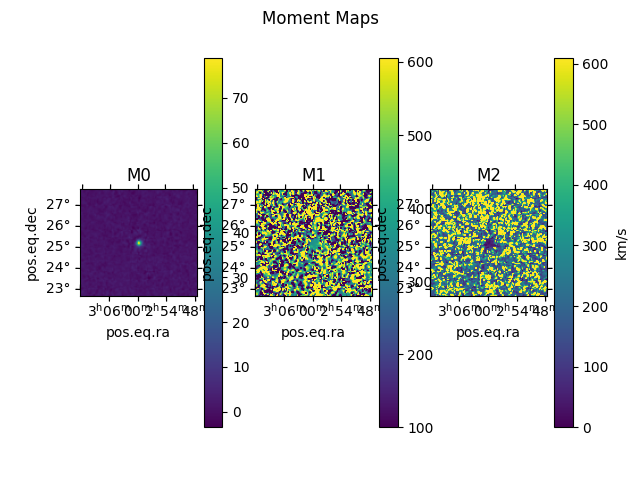

In [15]:
vis_mom(m0,m1,m2,wcs)

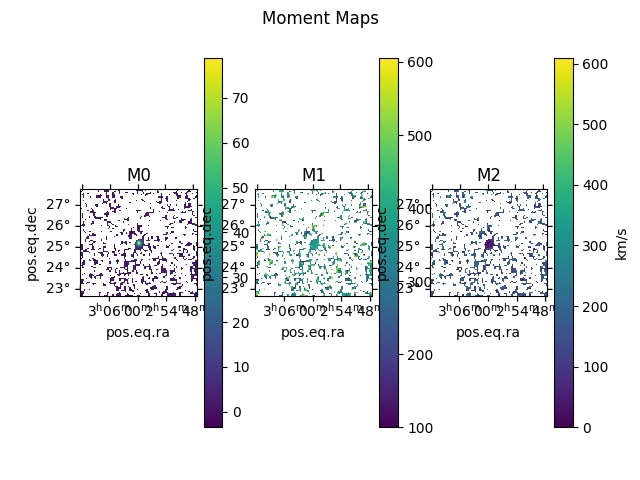

In [17]:
m1filt = np.where((m1 < 100) | (m1 > 606) | (m2<0)| (m2>506), np.nan, m1)
m2filt = np.where(np.isnan(m1filt),np.nan, m2)
m0filt = np.where(np.isnan(m1filt),np.nan, m0)

vis_mom(m0filt,m1filt,m2filt,wcs)

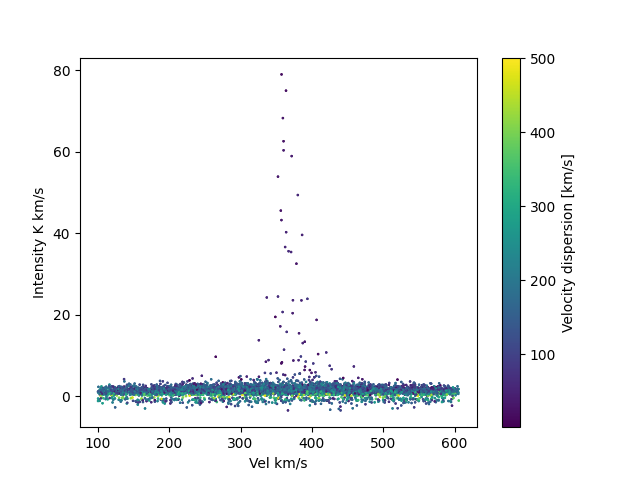

In [18]:
scatter_maps(m0filt,m1filt,m2filt,z=True)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


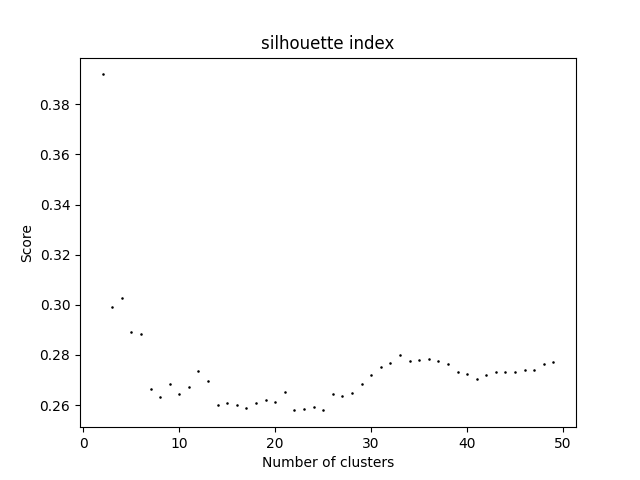

In [26]:
SI_analysis(m0filt,m1filt,m2filt,[2,50])

C:\Users\jonb7\AppData\Local\Temp\ipykernel_10160\1800600923.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


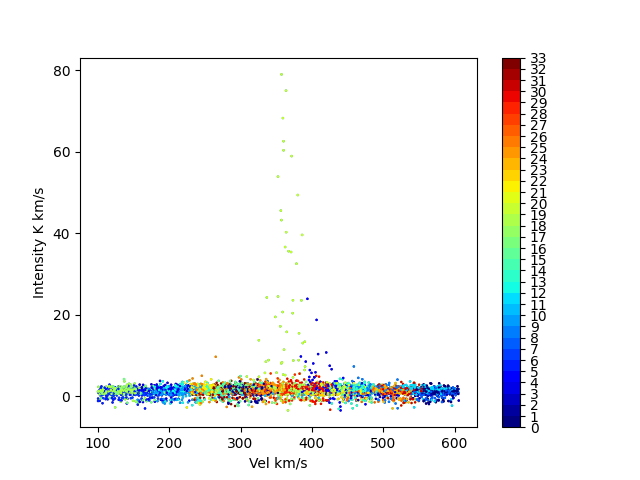

In [34]:
ClusterLabels,ClusterLabels_ = run_clustering(m0filt,m1filt,m2filt,33)

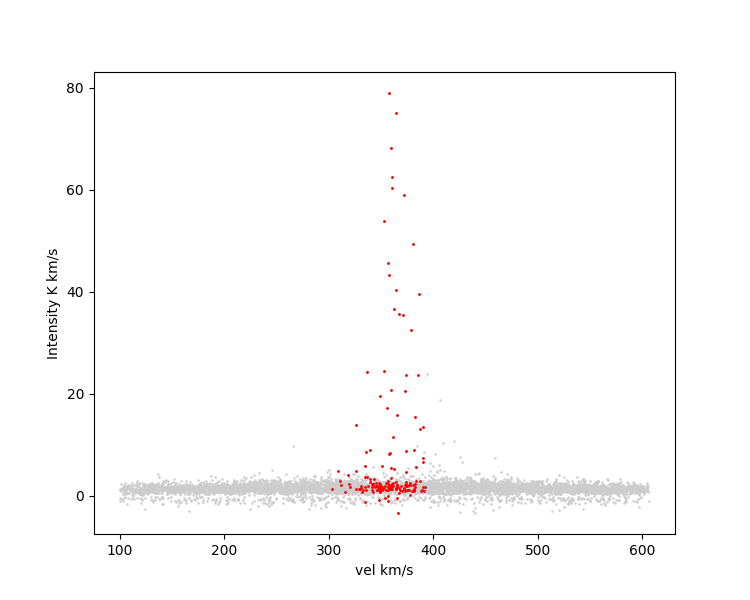

In [35]:
single_cluster_scatter(m0filt,m1filt,ClusterLabels,19)

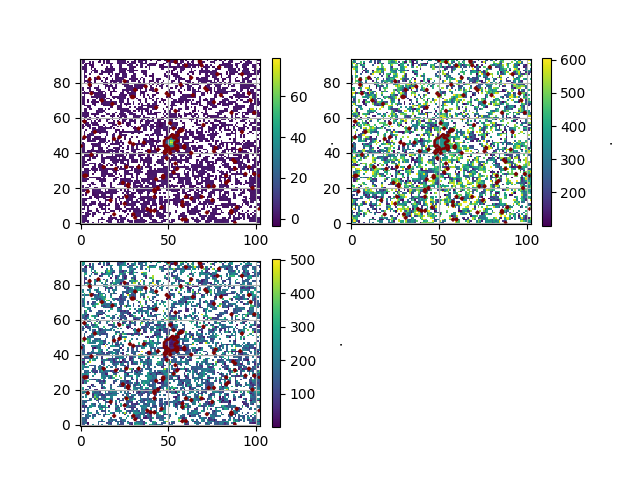

In [36]:
WorldMap_stitched([m0filt,m1filt,m2filt], contour=(ClusterLabels_, 19, getColors(ClusterLabels, 'jet_r')[0]), clabel = '.')

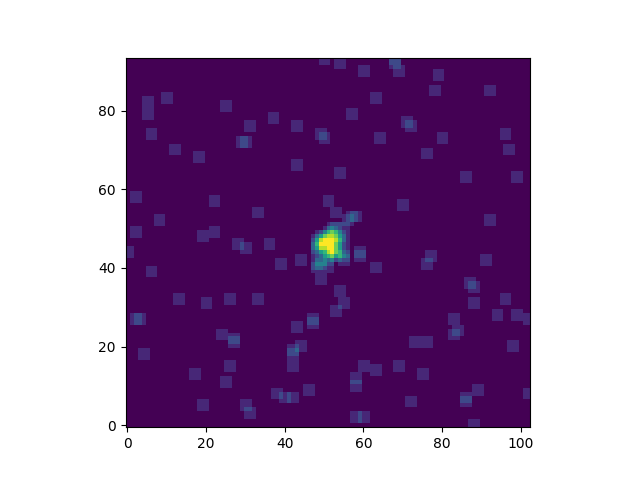

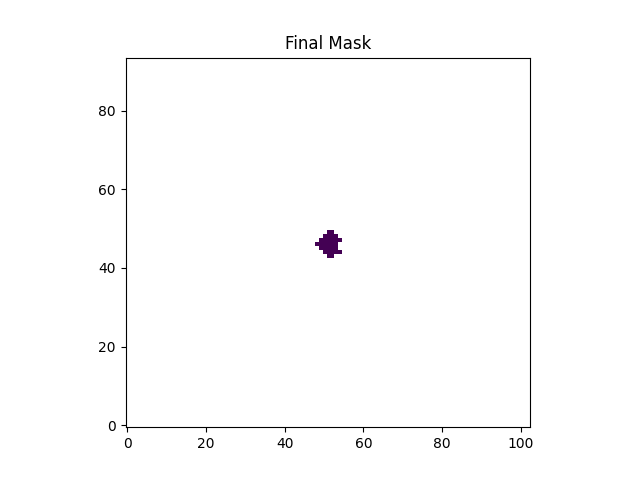

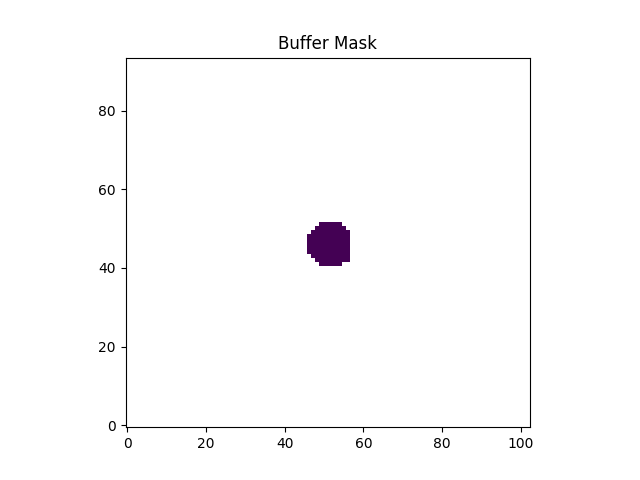

In [54]:
def make_mask(ClusterLabels_,cluster_no):

    gal_cluster_mask = np.where(ClusterLabels_!=cluster_no,np.nan, 1)#change this to chopose which cluster. Turns every non cluster pixel to nan
    return gal_cluster_mask

cluster_mask = make_mask(ClusterLabels_,19)


def mask_m0(m0,cluster_mask,num_neighbours):

    #create array showing neighbor sum.
    result_array = np.zeros_like(cluster_mask)
    for i in range(np.shape(m0)[0]):
        for j in range(np.shape(m0)[1]):
            neighbors_sum = np.nansum(cluster_mask[max(0, i-1):min(np.shape(m0)[0], i+2), max(0, j-1):min(np.shape(m0)[1], j+2)])
            result_array[i, j] = neighbors_sum

    neighbor_mask = np.where((result_array==np.nan)|(result_array<=num_neighbours),np.nan,cluster_mask)

    plt.figure()
    plt.imshow(result_array,origin='lower')#change vmin to min number of neighbours
    plt.show()

    fixed_mask = np.zeros_like(neighbor_mask)
    for x in range(np.shape(neighbor_mask)[0]):
        for y in range(np.shape(neighbor_mask)[1]):
            if neighbor_mask[x][y]>=0:
                fixed_mask[x][y]=1
            else:
                fixed_mask[x][y]=np.NaN

    plt.figure()
    plt.title('Final Mask')
    plt.imshow(fixed_mask,origin='lower')#change vmin to min number of neighbours
    plt.show()
    buffer_mask = buffer_pix(fixed_mask)
    plt.figure()
    plt.title('Buffer Mask')
    plt.imshow(buffer_mask,origin='lower')#change vmin to min number of neighbours
    plt.show()

    return buffer_mask

def buffer_pix(input_mask):
    new_mask = np.copy(input_mask)
    mask = input_mask
    
    offsets = [
        (0, 0), (1, 0), (-1, 0), (0, 1), (0, -1),
        (1, 1), (1, -1), (-1, 1), (-1, -1),
        (2, 1), (-2, 1), (1, 2), (1, -2),
        (2, -1), (-2, -1), (-1, 2), (-1, -2),
        (2, 0), (-2, 0), (0, 2), (0, -2),
        (2, 2), (2, -2), (-2, 2), (-2, -2)
    ]
    
    for i in range(1, np.shape(mask)[0]-2):
        for j in range(1, np.shape(mask)[1]-2):
            if mask[i, j] == 1:
                for offset_i, offset_j in offsets:
                    new_i, new_j = i + offset_i, j + offset_j
                    new_mask[new_i, new_j] = 1

    return new_mask


neighbor_mask =mask_m0(m0filt,cluster_mask,5)

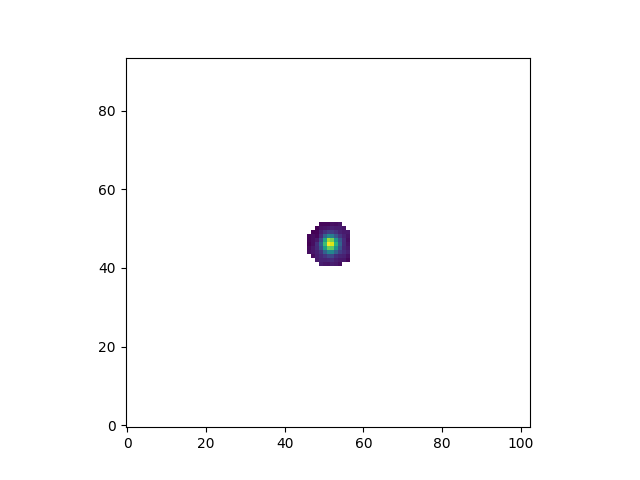

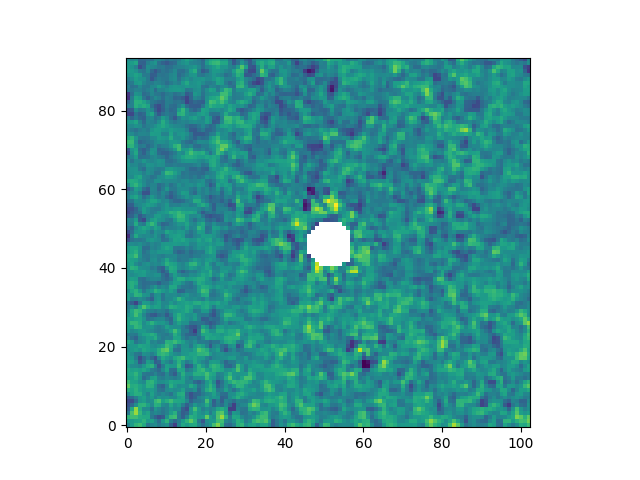

0.9465284
Flux=  118.42543453288575  Jy


In [66]:
def unit_conversion(temp):
    flux_jy = temp/1.28
    flux_BA = flux_jy/8.64
    return flux_BA

def flux_calc(moment_0,buffered_mask):
    #apply mask
    m0_masked = np.where(np.isnan(buffered_mask),np.nan,moment_0)
    inverse_masked_m0 = np.where(np.isnan(m0_masked),moment_0,np.nan)
    #inverse_masked_m0 = np.where((buffered_mask==1)|(gal_only_m0<=0),np.nan,gal_only_m0)
    
    plt.figure()
    plt.imshow(m0_masked,origin='lower')
    plt.show()
    plt.figure()
    plt.imshow(inverse_masked_m0,origin='lower')
    plt.show()
    #calculate background
    bg_per_pix =np.nanmean(inverse_masked_m0)
    print(bg_per_pix)

    gal_pix =np.sum(~np.isnan(m0_masked))

    clean_gal_flux = unit_conversion(np.nansum(m0_masked)-bg_per_pix*gal_pix)
    print('Flux= ', clean_gal_flux, ' Jy')
    return m0_masked, clean_gal_flux

t,y = flux_calc(m0,neighbor_mask)